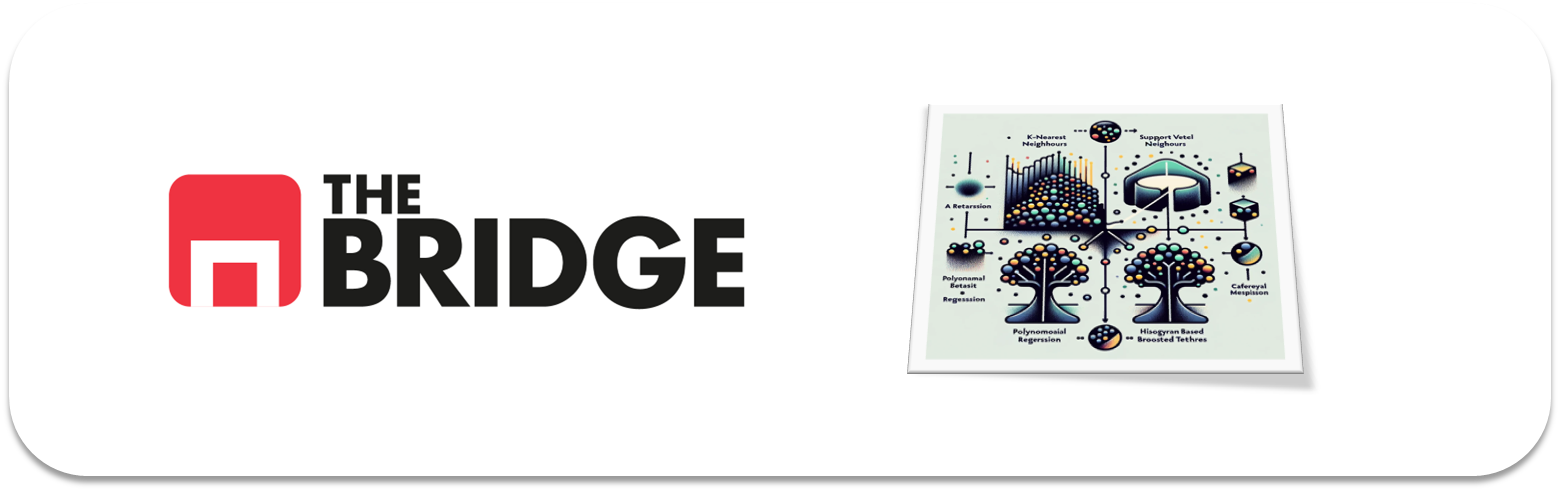

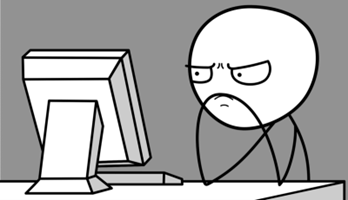

Para hacer un **repaso a los problemas de regresión con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Evaluación contra test.  
10. Análisis de errores, posibles acciones futuras.  
11. EXTRA: Persistencia del modelo en disco.  

### El problema de Negocio

El ayuntamiento de Freehold, Nueva Jersey, está preocupado por los niveles de Ozono en situaciones de contaminación. Ha adquirido unos sensores muy potentes que permiten medir la composición de la calidad del aire casi en tiempo real, pero desgraciadamente la medida de Ozono se obtiene mucho más tarde (casi 12 horas después, este dato de las horas no es relevante para el problema). Las medidas son enviadas a una plataforma central donde se quiere incorporar un modelo que en función de esas medidas pueda predecir el nivel de $O_3$ (Ozono) en el aire y establecer alarmas y umbrales para avisar a la población o tomar medidas si es necesaria.

El concejal de urbanismo y tecnología, Bruce S., os contrata para que creéis ese modelo y para ello os suministra un dataset con medidas de la calidad de aire donde han incorporado el nivel de Ozono ("PT08.S5(O3)") posteriormente. Quieren un modelo que se equivoque en media en menos de 100 unidades por millón (la medida en la que tienen registrada la presencia de Ozono).

¡Manos a la obra!

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [41]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

Nos piden que se equivoque en media menos de 100 unidades por millón, es decir nos dan el error en unidades de la variable target, emplearemos el MAE o RMSE o mejor, mediremos ambos aunque el MAE parece más alineado con lo que nos piden. En caso de duda, cotejar con Negocio

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [2]:
df = pd.read_csv('data/air_contamination.csv')
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       8991 non-null   int64  
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        8991 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        8991 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 913.3 KB


Podemos observar que todas nuestras variables son de tipo numérico float salvo la variable NHMC(GT) que es de tipo int. Habría que ver si la variable int es de tipo categórico para tenerlo en cuenta en el modelo. No hay ningún nulo en las variables.

In [4]:
target = 'PT08.S5(O3)'

### Ejercicio 3: Split

Haz el split en train y test.

In [5]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

### Ejercicio 4: MiniEDA (I)

Analiza la distribución del target brevemente.

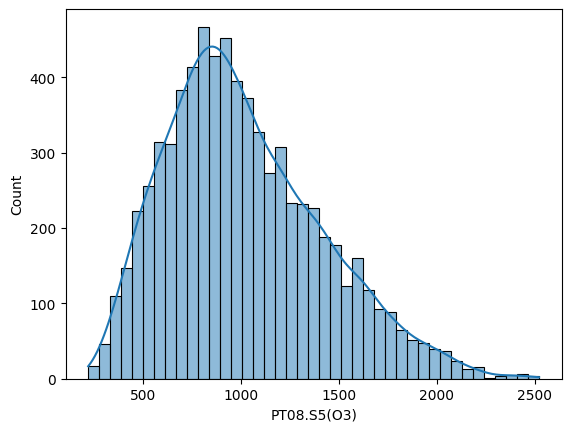

In [6]:
sns.histplot(train_set[target], kde = True);

Podemos observar que la variable target está desplazada hacia la izquierda. Tiene cierta 'normalidad', lo que es bueno para nuestro modelo de regresión lineal.

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, para las numéricas analiza la correlación numéricamente y gráficamente, para las categóricas analiza la distribución del target para cada valor de la categórica.

In [7]:
corr = train_set.corr(numeric_only= True)
np.abs(corr[target]).sort_values(ascending = False)

PT08.S5(O3)      1.000000
PT08.S1(CO)      0.901005
PT08.S2(NMHC)    0.879959
C6H6(GT)         0.864269
PT08.S3(NOx)     0.794185
NOx(GT)          0.623100
PT08.S4(NO2)     0.590688
NO2(GT)          0.337581
RH               0.133955
CO(GT)           0.128110
NMHC(GT)         0.110077
AH               0.069113
T                0.032899
Name: PT08.S5(O3), dtype: float64

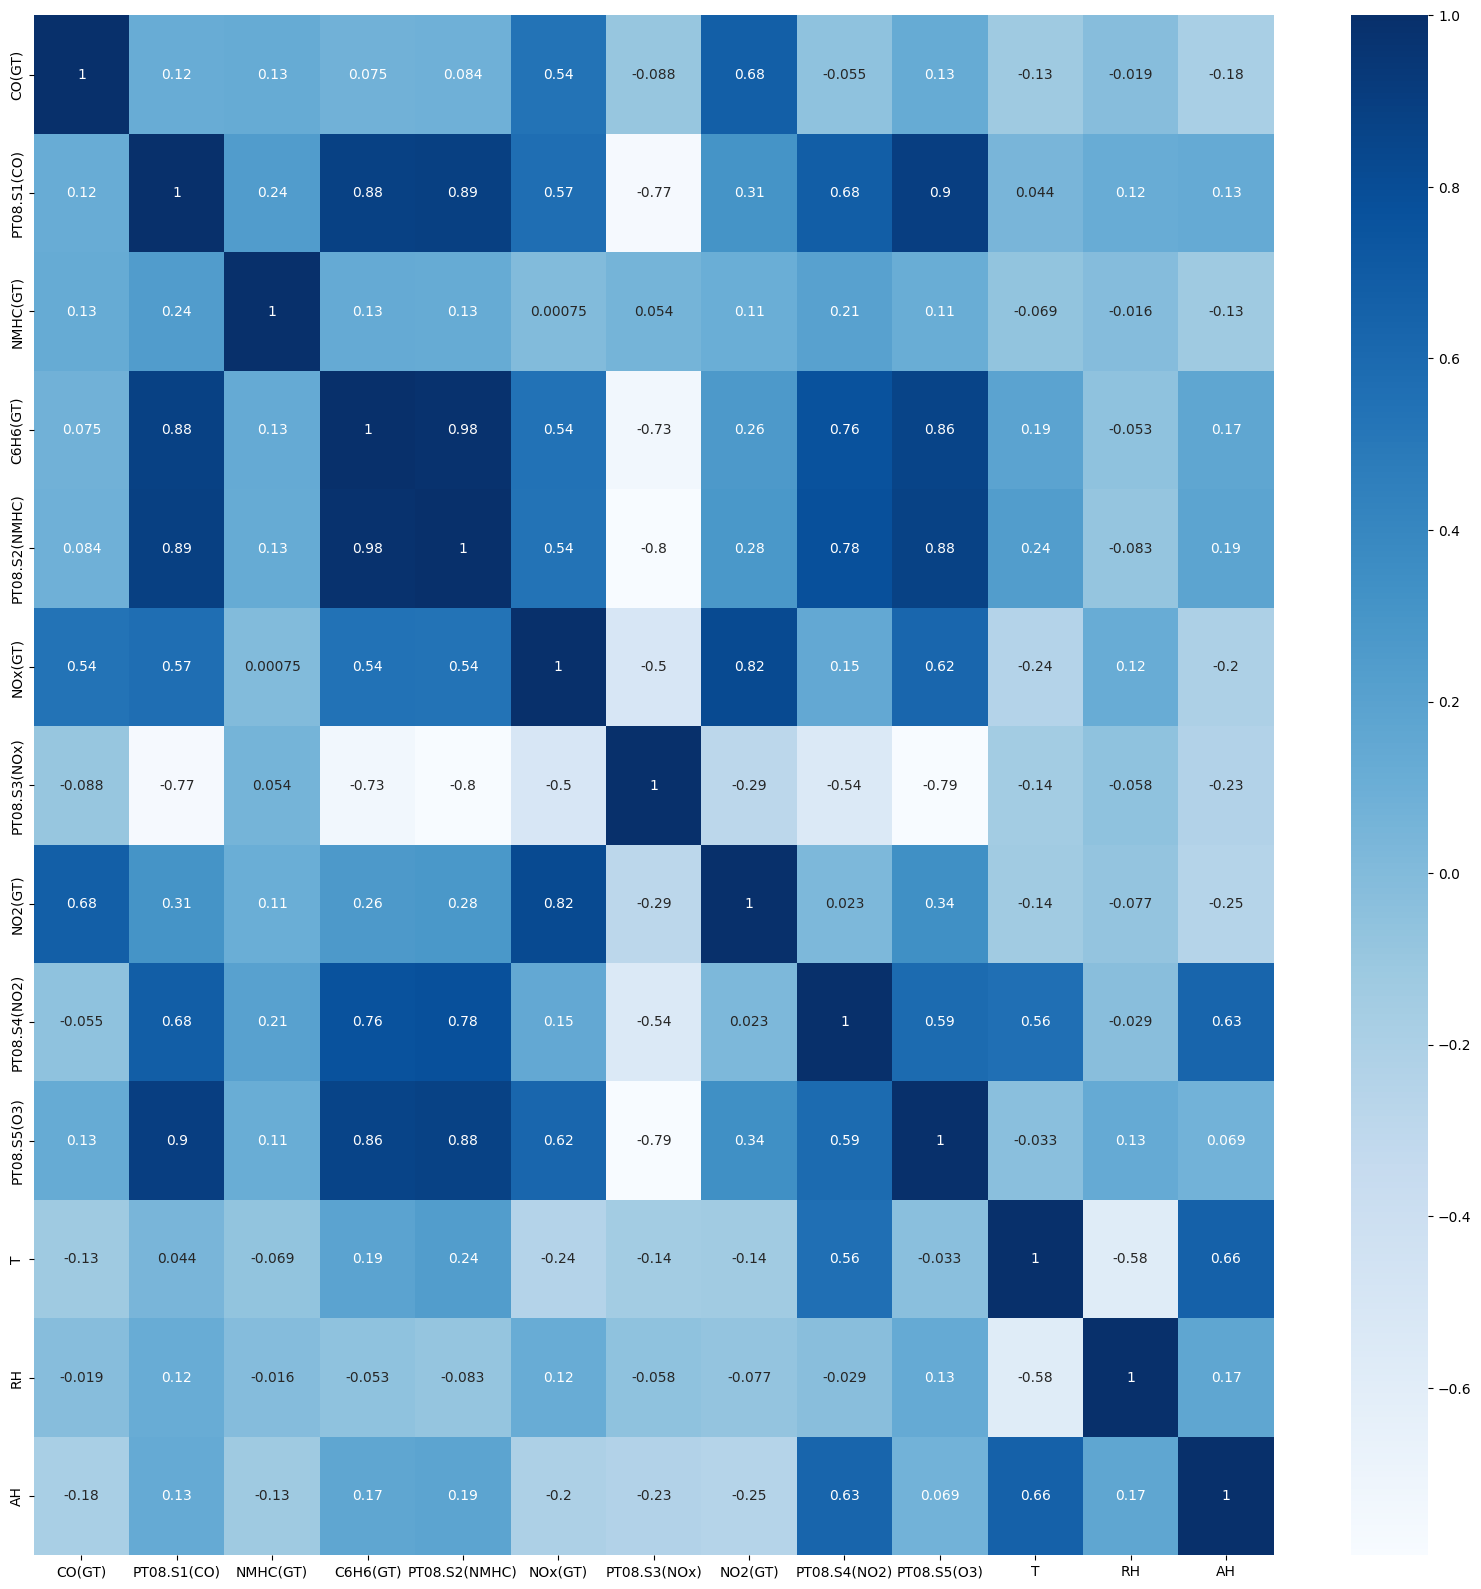

In [8]:
plt.figure(figsize = (20,20))
sns.heatmap(corr, annot=True, cmap = 'Blues');

Hacia 6 variables que tienen una correlación superior al 50% con la variable target. A primera vista estas son las variables que nos quedaremos para nuestro modelo. También se observa en el mapa de calor que algunas variables tienen alta colinealidad, por lo que habrá que quitarlas para no perjudicar al modelo.

In [9]:
features_num = train_set.columns.to_list()

In [10]:
criterio_col = 0.7
excluidas = []
for col in features_num:
    print(f"Voy a comprobar la colinealidad con {col}")
    if col not in excluidas:
        for col_2,valor_corr in corr[col].items():
            print(f"Comprobando con {col_2}")
            if col != col_2 and col_2 in features_num:
                if np.abs(valor_corr) >= criterio_col:
                    print(f"Correlo al {valor_corr}, por eso excluyo a {col_2}")
                    excluidas.append(col_2)
                else:
                    print(f"Conmigo no tiene problema, dejo a {col_2} tranquila")
            elif col == col_2:
                print("soy yo misma, no me excluyo")
            else:
                print("No estaba ya en la lista original, no hago nada")
excluidas = list(set(excluidas))

Voy a comprobar la colinealidad con CO(GT)
Comprobando con CO(GT)
soy yo misma, no me excluyo
Comprobando con PT08.S1(CO)
Conmigo no tiene problema, dejo a PT08.S1(CO) tranquila
Comprobando con NMHC(GT)
Conmigo no tiene problema, dejo a NMHC(GT) tranquila
Comprobando con C6H6(GT)
Conmigo no tiene problema, dejo a C6H6(GT) tranquila
Comprobando con PT08.S2(NMHC)
Conmigo no tiene problema, dejo a PT08.S2(NMHC) tranquila
Comprobando con NOx(GT)
Conmigo no tiene problema, dejo a NOx(GT) tranquila
Comprobando con PT08.S3(NOx)
Conmigo no tiene problema, dejo a PT08.S3(NOx) tranquila
Comprobando con NO2(GT)
Conmigo no tiene problema, dejo a NO2(GT) tranquila
Comprobando con PT08.S4(NO2)
Conmigo no tiene problema, dejo a PT08.S4(NO2) tranquila
Comprobando con PT08.S5(O3)
Conmigo no tiene problema, dejo a PT08.S5(O3) tranquila
Comprobando con T
Conmigo no tiene problema, dejo a T tranquila
Comprobando con RH
Conmigo no tiene problema, dejo a RH tranquila
Comprobando con AH
Conmigo no tiene prob

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [11]:
features_all = train_set.columns.to_list()
features_all.remove(target)
r_umbral = 0.15
correlaciones = np.abs(corr[target])
features_num_1 = correlaciones[correlaciones > 0.15].index.to_list()
features_num_1

['PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)']

In [12]:
criterio_col = 0.7
excluidas = []
for col in features_num_1:
    print(f"Voy a comprobar la colinealidad con {col}")
    if col not in excluidas:
        for col_2,valor_corr in corr[col].items():
            print(f"Comprobando con {col_2}")
            if col != col_2 and col_2 in features_num:
                if np.abs(valor_corr) >= criterio_col:
                    print(f"Correlo al {valor_corr}, por eso excluyo a {col_2}")
                    excluidas.append(col_2)
                else:
                    print(f"Conmigo no tiene problema, dejo a {col_2} tranquila")
            elif col == col_2:
                print("soy yo misma, no me excluyo")
            else:
                print("No estaba ya en la lista original, no hago nada")
excluidas = list(set(excluidas))
features_num_0 = [col for col in features_num_1 if col not in excluidas]
print("Excluidas: ", excluidas)
print("Set reducido de features:", features_num_0)

Voy a comprobar la colinealidad con PT08.S1(CO)
Comprobando con CO(GT)
Conmigo no tiene problema, dejo a CO(GT) tranquila
Comprobando con PT08.S1(CO)
soy yo misma, no me excluyo
Comprobando con NMHC(GT)
Conmigo no tiene problema, dejo a NMHC(GT) tranquila
Comprobando con C6H6(GT)
Correlo al 0.8849615905270112, por eso excluyo a C6H6(GT)
Comprobando con PT08.S2(NMHC)
Correlo al 0.893617834782422, por eso excluyo a PT08.S2(NMHC)
Comprobando con NOx(GT)
Conmigo no tiene problema, dejo a NOx(GT) tranquila
Comprobando con PT08.S3(NOx)
Correlo al -0.7710516010457255, por eso excluyo a PT08.S3(NOx)
Comprobando con NO2(GT)
Conmigo no tiene problema, dejo a NO2(GT) tranquila
Comprobando con PT08.S4(NO2)
Conmigo no tiene problema, dejo a PT08.S4(NO2) tranquila
Comprobando con PT08.S5(O3)
Correlo al 0.9010046336109274, por eso excluyo a PT08.S5(O3)
Comprobando con T
Conmigo no tiene problema, dejo a T tranquila
Comprobando con RH
Conmigo no tiene problema, dejo a RH tranquila
Comprobando con AH
C

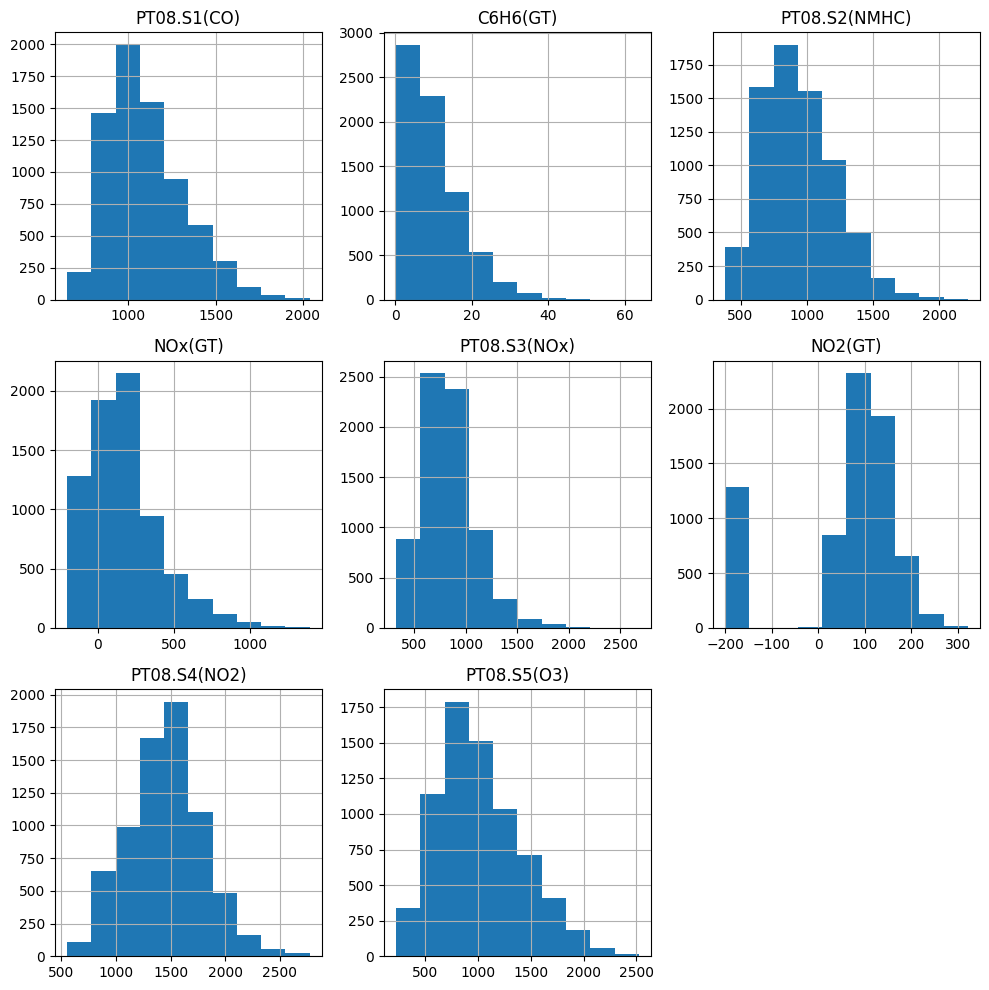

In [13]:
train_set[features_num_1].hist(figsize = (10,10))
plt.tight_layout()
plt.show()

Viendo las representaciones anteriores hay variables que tienen que ser tratadas para el modelo aunque no será necesario debido al tipo de modelos que usaremos.

In [14]:
modelos = ['RandomForest Regressor', 'XGB Regressor', 'LGBM Regressor']

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

No es necesario tratar las features ya que los modelos que vamos a utilizar no son sensibles para el escalado.

### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [30]:
y_train = train_set[target]
y_test = test_set[target]

features_set_names = ['reducido','alta_correlacion','completo']

x_train_dict = {}
x_test_dict = {}

for nombre, feature_list in zip(features_set_names, [features_num_0, features_num_1, features_all]):
    x_train_dict[nombre] = train_set[feature_list]
    x_test_dict[nombre] = test_set[feature_list]

### Ejercicios 9:

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. 

In [31]:
rf_reg = RandomForestRegressor(random_state = 42, max_depth = 5)
xgb_reg = XGBRegressor(random_state = 42, max_depth = 5)
lgbm_reg = LGBMRegressor(random_state = 42, max_depth = 5, verbose = -100)

### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea "mean_absolute_error" (recuerda el funcionamiento del scoring en "sklearn", no te valdrá poner "mean_absolute_error"). Escoge el modelo ganador.

In [34]:
modelos = {
    'Random Forest reg': rf_reg,
    'XGB reg': xgb_reg,
    'LGBM reg': lgbm_reg
}


for feature_set, x_train in x_train_dict.items():
    print(f'Para el set {feature_set}:')
    for tipo, modelo in modelos.items():
        print(f'{tipo}:', end='')
        metrica = np.mean(cross_val_score(modelo, x_train, y_train, cv=5, scoring="neg_mean_absolute_error"))
        print(abs(metrica))
    print('*****')

Para el set reducido:
Random Forest reg:117.98382052235979
XGB reg:109.43437450784366
LGBM reg:106.99746677444679
*****
Para el set alta_correlacion:
Random Forest reg:7.520697848190356
XGB reg:3.2862543227420273
LGBM reg:2.6734431097030287
*****
Para el set completo:
Random Forest reg:103.11283300292203
XGB reg:79.87781654659872
LGBM reg:81.05394079935814
*****


### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "mean absolute error". 

In [36]:
param_grid = {
    'num_leaves': [5,10,31,100],
    'learning_rate': [0.1,0.3,1],
    'class_weight': ['balanced',None],
    'n_estimators': [20,50,100]
}

lgbm_grid = GridSearchCV(
    lgbm_reg,
    param_grid = param_grid,
    cv = 5,
    scoring = 'neg_mean_absolute_error'
)
lgbm_grid.fit(x_train_dict[features_set_names[1]], y_train)

GridSearchCV(cv=5,
             estimator=LGBMRegressor(max_depth=5, random_state=42,
                                     verbose=-100),
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.3, 1],
                         'n_estimators': [20, 50, 100],
                         'num_leaves': [5, 10, 31, 100]},
             scoring='neg_mean_absolute_error')

In [37]:
lgbm_grid.best_score_

-2.4724386055289065

In [38]:
lgbm_grid.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.1,
 'n_estimators': 100,
 'num_leaves': 31}

### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [42]:
y_pred = lgbm_grid.best_estimator_.predict(x_test_dict[features_set_names[1]])
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', root_mean_squared_error(y_test, y_pred))

MAE: 2.6363074068676022
RMSE: 9.501724489067032


### Ejercicio 13: Análisis de errores

Comparar los valores predichos contra los reales mediante una gráfica (puedes emplear la función que empleamos en el workout de la unidad anterior). Haz un pequeño análisis.

In [46]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(10, 10))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

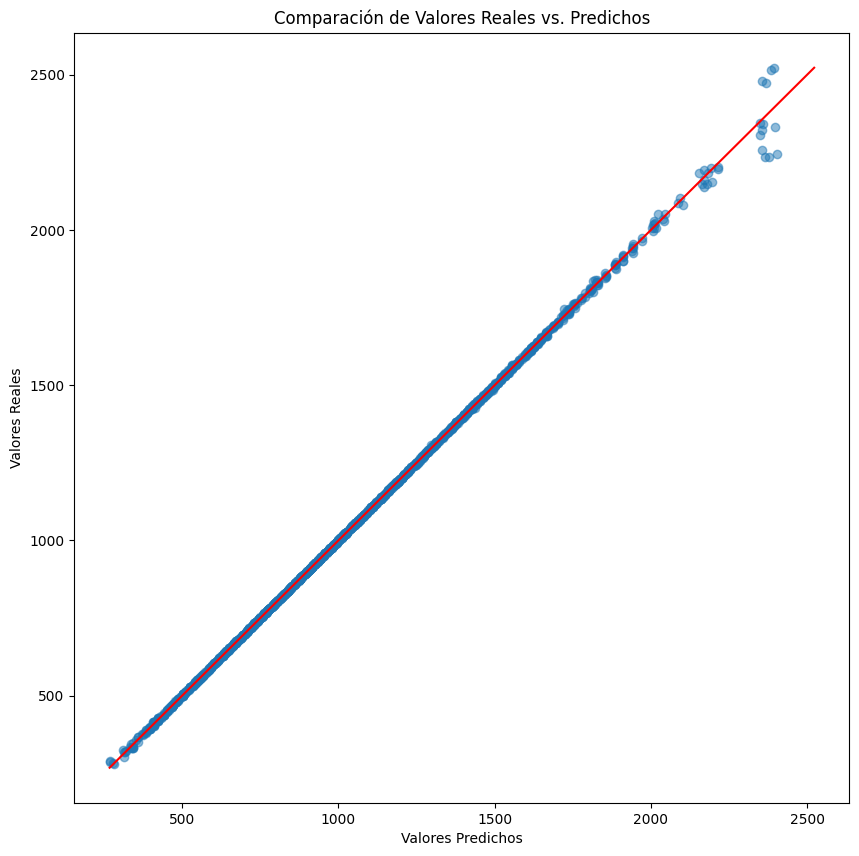

In [47]:
plot_predictions_vs_actual(y_test, y_pred)

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/o3_pred" con la extesión apropiada.

In [48]:
import pickle

# Creamos el directorio si no existe
os.makedirs("models", exist_ok= True)


# Guardar el modelo en un archivo
with open('o3_pred.pkl', 'wb') as file:
    pickle.dump(lgbm_grid.best_estimator_, file)

In [59]:
# Para cargarlo


# Cargar el modelo
with open('o3_pred.pkl', 'rb') as file:
    model = pickle.load(file)

# Ahora 'model' está listo para usarse como antes
y_pred = model.predict(x_train_dict[features_set_names[1]])

In [61]:
y_test.shape

(1799,)

In [62]:
y_pred.shape

(7192,)

ValueError: x and y must be the same size

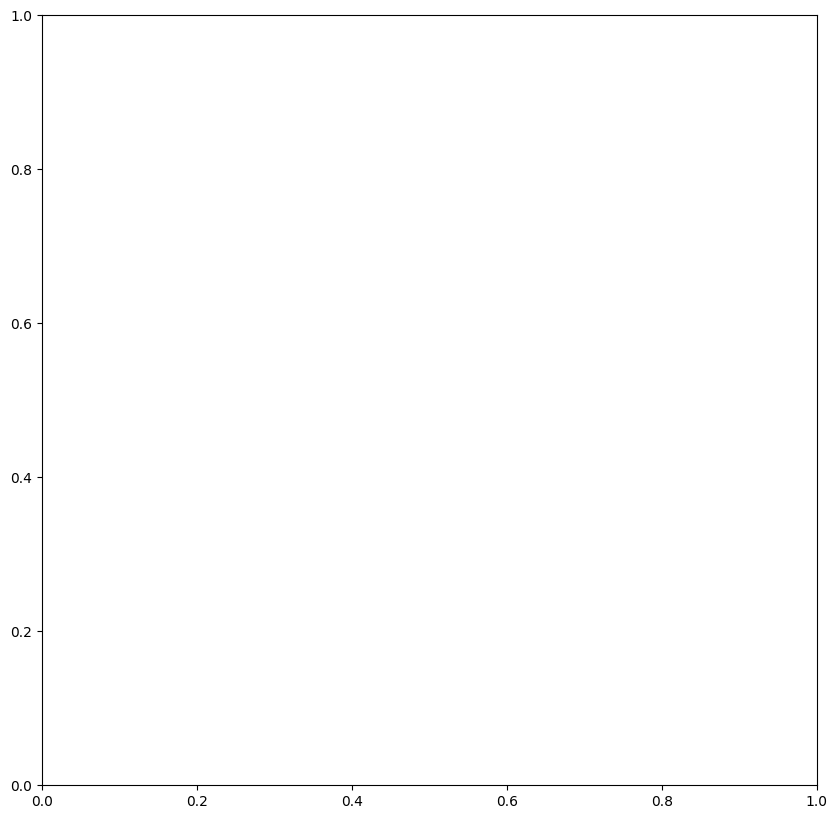

In [60]:
plot_predictions_vs_actual(y_test, y_pred)